In [2]:
import pymysql
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime as dt
import math
from random import *
from dateutil.parser import parse
warnings.filterwarnings("ignore")
%matplotlib inline

plt.style.use('ggplot')

In [33]:
start = '20140801' # '20110101'
end = '20200331'

dt_index = pd.DataFrame(pd.date_range(start=start, end=end, freq = 'B')).rename(columns = {0 : 'date'})
dt_month_index = pd.DataFrame(pd.date_range(start=start, end=end,freq='MS')).rename(columns = {0 : 'date'})

def processing_potato_price(data):
    # print("======= data processing start ===========")
    # print(data.shape)
    # 중복값 제거
    data = data.drop_duplicates()
       
    # before, now / string to int
    data['before'] = data['before'].apply(lambda x : int(x.replace(',','')))
    data['now'] = data['now'].apply(lambda x : int(x.replace(',','')))
    
    # name 통합
    data['name'] = data['name'].apply(lambda x : x.replace('감자(수미)', '감자 수미').replace('감자(대지마)', '감자 대지'))
    
    # 감자 수미 or 감자 대지 선택
    string = '감자 수미' # 감자 수미 or 감자 대지
    subdata = data[data['name'] == '감자 대지']
    data = data[data['name'] == string]
    
    # 20110101-20191231 인덱스 설정
    data['date'] = data['date'].apply(lambda x : parse(str(x)))
    data = pd.merge(dt_index, data, how = 'left', on = 'date').set_index('date')
    
    subdata['date'] = subdata['date'].apply(lambda x : parse(str(x)))
    subdata = pd.merge(dt_index, subdata, how = 'left', on = 'date').set_index('date')
    
    # name 통일
    data['name'] = string
    
    # null 값 채우기
    # 1) 0값을 null값으로
    def zero_to_nan(data):
        if math.isnan(data): return data
        elif data == 0: return np.nan
        else: return data

    data['before'] = data['before'].apply(zero_to_nan)
    data['now'] = data['now'].apply(zero_to_nan)
    
    # 2) now가 null 값일 때 다음날 before값이 존재할 때
    random_value = 10
    data['Fill_value'] = data.shift(-1)['before']
    data['now'] = data[['now', 'Fill_value']].apply(lambda x : x['Fill_value'] if math.isnan(x['now']) else x['now'], axis = 1)
    
    # 3) 2014-04-01 ~ 2015-04-40 수미 감자 null 값을 대지 감자 price로 대체
    data['sub_now'] = subdata['now']
    data['tmp_date'] = data.index
    def fill_null_to_sub_now(data):
        if str(data['tmp_date']) > '2014-03-31' and str(data['tmp_date']) <= '2015-04-30': return data['sub_now']
        else: return data['now']
    data['now'] = data[['now','tmp_date','sub_now']].apply(fill_null_to_sub_now, axis = 1)
    
    # 4) 이전 날의 값으로 null값 대체
    data = data.fillna(method='ffill')
    data = data.fillna(method='bfill')
    
    # 불필요한 columns drop
    data.drop(['name','before','Fill_value','sub_now','tmp_date'],axis = 1,inplace = True)
    data.rename(columns = {'now' : 'potato_price'}, inplace = True)
    # print(data.head())
    # print(data.isnull().sum().sum())
    print(data.head(3))
    # print("======= data processing finish ===========")
    print()
    return data

In [34]:
def processing_Exchange_Rate(data):
    # 20110101부터 정렬
    data = data[::-1]
    # format datetime으로 변경
    data['날짜'] = data['날짜'].apply(lambda x : parse(x[:4] + x[6:8] + x[10:12]))
    # 20110101-20191231 인덱스 설정
    data = pd.merge(dt_index, data, how = 'left', left_on='date', right_on='날짜').set_index('date')
    #print('전처리 전 null 갯수 : {}'.format(data['종가'].isnull().sum()))
    # type 변경 str -> float
    data['종가'] = data['종가'].apply(lambda x : x if x is np.nan else float(x.replace(',','')))
    data['오픈'] = data['오픈'].apply(lambda x : x if x is np.nan else float(x.replace(',','')))
    
    # 주말 Null값 채우기
        
    # 일요일 : 월요일 오픈 가격으로 대체
    data['Fill_value'] = data.shift(-1)['오픈']
    data['종가'] = data[['종가', 'Fill_value']].apply(lambda x : x['Fill_value'] if math.isnan(x['종가']) else x['종가'], axis = 1)
    #print('전처리 후 null 갯수 : {}'.format(data['종가'].isnull().sum()))
    
    # 토요일 : 금요일 종가 + random value
    random_value = 1
    data['Fill_value'] = data.shift(1)['종가']
    data['종가'] = data[['종가', 'Fill_value']].apply(lambda x : x['Fill_value'] + uniform(-random_value, random_value) if math.isnan(x['종가']) else x['종가'], axis = 1)

    data.drop(['날짜', '오픈', '고가', '저가', '변동 %', 'Fill_value'], axis = 1, inplace = True)    
                      
    #print('전처리 후 null 갯수 : {}'.format(data['종가'].isnull().sum()))
    data.rename(columns = {'종가' : 'Exchange_Rate'}, inplace = True)
    
    data = data.fillna(method='bfill')
    print(data.head(3))
    print()
    return data

In [35]:
def processing_KOSPI(data):
    # 20110101부터 정렬
    data = data[::-1]
    
    # format datetime으로 변경
    data['날짜'] = data['날짜'].apply(lambda x : parse(x[:4] + x[6:8] + x[10:12]))
    
    # 20110101-20191231 인덱스 설정
    data = pd.merge(dt_index, data, how = 'left', left_on='date', right_on='날짜').set_index('date')
    # type 변경 str -> float
    data['종가'] = data['종가'].apply(lambda x : x if x is np.nan else float(x.replace(',','')))
    data['오픈'] = data['오픈'].apply(lambda x : x if x is np.nan else float(x.replace(',','')))
    
    
    # 주말 Null값 채우기
        
    # 일요일 : 월요일 오픈 가격으로 대체
    data['Fill_value'] = data.shift(-1)['오픈']
    data['종가'] = data[['종가', 'Fill_value']].apply(lambda x : x['Fill_value'] if math.isnan(x['종가']) else x['종가'], axis = 1)
    
    random_value = 1
    data['Fill_value'] = data.shift(1)['종가']
    data['종가'] = data[['종가', 'Fill_value']].apply(lambda x : x['Fill_value'] + uniform(-random_value, random_value) if math.isnan(x['종가']) else x['종가'], axis = 1)
    
    pd.set_option('display.float_format', '{:.2f}'.format) # 항상 float 형식으로
    
    data.drop(['날짜', '오픈', '고가', '저가', '거래량','변동 %', 'Fill_value'], axis = 1, inplace = True)    
    data.rename(columns = {'종가' : 'KOSPI'}, inplace = True)
    
    data = data.fillna(method='bfill')
    print(data.head(3))
    print()
    return data

In [36]:
def processing_Consumer_trend_survey(data):
    data = data.T
    data.columns = data.loc['항목명1', :]
    data = data.iloc[17:-3, :5].astype('int').reset_index()
    
    # Consumer_trend_survey
    result = pd.concat([dt_month_index, data], axis = 1, ignore_index=True).set_index(0)
    result.columns = data.columns    
    
    result.drop(['index'], axis = 1, inplace = True)
    
    print(result.head(3))
    print()
    return result

In [37]:
def processing_Oil_prices(data):
    data['날짜'] = data['기간'].apply(lambda x : parse('20' + x[:2] + x[3:5] + x[6:8]))
    
    data = pd.merge(dt_index, data, how = 'left', left_on='date', right_on='날짜').set_index('date')
    
    # null 값 처리
    data = data.fillna('-')
    data['Dubai'] = data['Dubai'].apply(lambda x : np.nan if x == '-' else float(x))
    data['Brent'] = data['Brent'].apply(lambda x : np.nan if x == '-' else float(x))
    data['WTI'] = data['WTI'].apply(lambda x : np.nan if x == '-' else float(x))
    
    data = data.fillna(method='bfill')
    data.drop(['기간','날짜'], axis = 1, inplace = True)    
    
    print(data.head(3))
    print()
    return data

In [38]:
def processing_Market_interest_rates(data):
    data = data.iloc[3:-8,:].rename(columns = {'통계표' : '날짜', '4.1.1 시장금리(일별)' : '시장금리'})
    
    data['날짜'] = data['날짜'].apply(lambda x : parse(x))
    data = pd.merge(dt_index, data, how = 'left', left_on='date', right_on='날짜').set_index('date')
    
    data['시장금리'] = data['시장금리'].apply(lambda x : x if x is np.nan else float(x))
    data = data.fillna(method='bfill')
    
    data.drop(['날짜'], axis = 1, inplace = True)
    
    print(data.head(3))
    print()
    return data

In [39]:
def load_data(sql):
    # print("======= data loading start ===========")
    conn = pymysql.connect(host='192.168.1.254', user='root', password='123456',
                           db='crawling', charset='utf8')
    curs = conn.cursor()
    curs.execute(sql)
    rows = curs.fetchall()
    # print("{}개의 데이터 로딩".format(len(rows)))
    data = pd.DataFrame(rows, columns=['name','now','before','date'])
    # print(data.head(3))
    # print("======= data loading finish ===========")
    # print()
    return data

def load_potato_price():
    sql = """
    SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date`
    FROM tbl_item WHERE tbl_item.`date` > '2011-01-01' and tbl_item.`품목` LIKE CONCAT('%' ,'%감자','%') 
    ORDER BY tbl_item.date ASC 
    """
    return load_data(sql)

def load_tomato_price():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item  
    WHERE tbl_item.`품목` LIKE '방울토마토%'
    """
    return load_data(sql)

def load_green_pepper():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item  
    WHERE tbl_item.`품목` IN ('풋고추(일반)', '풋고추')
    """
    return load_data(sql)

def load_red_pepper():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item 
    WHERE tbl_item.`품목` IN ('풋고추(청양계)', '청양계풋고추')
    """
    return load_data(sql)

def load_cabbage():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item 
    WHERE tbl_item.`품목` LIKE '배추%'
    """
    return load_data(sql)

def load_cabbage1():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item 
    WHERE tbl_item.`품목` LIKE '양배추'
    """
    return load_data(sql)

def load_onion():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item 
    WHERE tbl_item.`품목` LIKE '양파'
    """
    return load_data(sql)

def load_carrot():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item 
    WHERE tbl_item.`품목` LIKE '당근'
    """
    return load_data(sql)

def load_green_onion():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item 
    WHERE tbl_item.`품목` LIKE '대파%'
    """
    return load_data(sql)

def load_cucumber():
    sql = """SELECT tbl_item.`품목`, tbl_item.`당일`, tbl_item.`전일`, tbl_item.`date` FROM tbl_item 
    WHERE tbl_item.`품목` LIKE '%백다다기%'
    """
    return load_data(sql)

def processing_data(data, name):
    data['now'] = data['now'].apply(lambda x : int(x.replace(',','')))
    data['before'] = data['before'].apply(lambda x : int(x.replace(',','')))
    data['date'] = data['date'].apply(lambda x : parse(str(x)))
    
    data = pd.merge(dt_index, data, how = 'left', left_on='date', right_on='date').set_index('date')
    
    # fill null value
    def zero_to_nan(data):
        if math.isnan(data): return data
        elif data == 0: return np.nan
        else: return data

    data['before'] = data['before'].apply(zero_to_nan)
    data['now'] = data['now'].apply(zero_to_nan)
    
    data['Fill_value'] = data.shift(-1)['before']
    data['now'] = data[['now', 'Fill_value']].apply(lambda x : x['Fill_value'] if math.isnan(x['now']) else x['now'], axis = 1)
    
    data = data.fillna(method='ffill')
    data = data.fillna(method='bfill').rename(columns = {'now' : name})
    
    data.drop(['name','before','Fill_value'], axis = 1, inplace = True)
    
    print(data.head(3))
    print()
    return data

In [40]:
def load_stock_data(sql):
    # print("======= data loading start ===========")
    conn = pymysql.connect(host='192.168.1.23', user='root', password='1231',
                           db='bms_test', charset='utf8')
    curs = conn.cursor()
    curs.execute(sql)
    rows = curs.fetchall()
    # print("{}개의 데이터 로딩".format(len(rows)))
    data = pd.DataFrame(rows)#, columns=['name','now','before','date'])
    # print(data.head(3))
    # print("======= data loading finish ===========")
    # print()
    return data

def processiong_stock_data(name, col_name):
    
    sql = 'SELECT DATE, price_closing FROM stock_day WHERE com_name LIKE \'' + name + '\' and DATE > \'2010-01-01\'' 

    data = load_stock_data(sql)
    
    data = data.rename(columns = {0 : 'date', 1 : col_name})
    data['date'] = data['date'].apply(lambda x : parse(str(x)))
    data[col_name] = data[col_name].apply(lambda x : int(x.replace(',','')))
    
    data = pd.merge(dt_index, data, how = 'left', left_on='date', right_on='date')#.set_index('date')
    
    data = data.fillna(method='ffill').set_index('date')
    
    print(data.head(3))
    print()
    
    return data

In [41]:
if __name__ == "__main__":
    print('==========감자 가격 전처리=============')
    potato_price = processing_potato_price(load_potato_price())
    
    print('========방울토마토 가격 전처리==========')
    tomato_price = processing_data(load_tomato_price(), 'tomato')
    
    print('==========풋고추 가격 전처리============')
    green_pepper_price = processing_data(load_green_pepper(), 'green_pepper')
    
    print('==========청양고추 가격 전처리============')
    red_pepper_price = processing_data(load_red_pepper(), 'red_pepper')
    
    print('==========배추 가격 전처리============')
    cabbage_price = processing_data(load_cabbage(), 'cabbage')
    
    print('=========양배추 가격 전처리============')
    cabbage1_price = processing_data(load_cabbage1(), 'cabbage1')
    
    print('=========양파 가격 전처리============')
    onion_price = processing_data(load_onion(), 'onion')
    
    print('=========당근 가격 전처리============')
    carrot_price = processing_data(load_carrot(), 'carrot')
    
    print('=========대파 가격 전처리============')
    green_onion_price = processing_data(load_green_onion(), 'green_onion')
    
    print('=========오이 가격 전처리============')
    cucumber_price = processing_data(load_cucumber(), 'cucumber')
    
    print('============환율 전처리================')
    Exchange_Rate = processing_Exchange_Rate(pd.read_csv('USD_KRW.csv'))

    print('============코스피 전처리==============')
    KOSPI = processing_KOSPI(pd.read_csv('코스피지수 내역.csv'))

    print('========소비자 동향조사 전처리==========')
    Consumer_trend_survey = processing_Consumer_trend_survey(pd.read_csv('소비자동향조사.csv', encoding = 'cp949'))

    print('========국제 원유 가격 전처리==========')
    Oil_prices = processing_Oil_prices(pd.read_csv('원유(일).csv', encoding='cp949'))
    
    print('============시장 금리 전처리============')
    Market_interest_rates = processing_Market_interest_rates(pd.read_csv('시장금리(일).csv', encoding = 'cp949', error_bad_lines=False))

    print('=========아시아종묘 주식 전처리============')
    Stock_Asia = processiong_stock_data('아시아종묘', 'stock_Asia')
    
    print('==============조비 주식 전처리==============')
    stock_Jobi = processiong_stock_data('조비', 'stock_Jobi')
    
    print('==========효성오앤비 주식 전처리==========')
    stock_Hyosung = processiong_stock_data('효성오앤비', 'stock_Hyosung')
    
    print('==========경농 주식 전처리==========')
    stock_Farming = processiong_stock_data('경농', 'stock_Farming')
    
    print('==========남해화학 주식 전처리==========')
    stock_Namhae_Chemical = processiong_stock_data('남해화학', 'stock_Namhae_Chemical')
    
    print('==========KG케미칼 주식 전처리==========')
    stock_KGChemical = processiong_stock_data('KG케미칼', 'stock_KGChemical')
    
    print('==========농우바이오 주식 전처리==========')
    stock_Nongwoo_Bio = processiong_stock_data('농우바이오', 'stock_Nongwoo_Bio')
    
    print('==========성보화학 주식 전처리==========')
    stock_Sungbo_Chemical = processiong_stock_data('성보화학', 'stock_Sungbo_Chemical')
    
    print('==========아세아텍 주식 전처리==========')
    stock_Asia_Tech = processiong_stock_data('아세아텍', 'stock_Asia_Tech')
    
    print('==========동방아그로 주식 전처리==========')
    stock_Eastern_Agro = processiong_stock_data('동방아그로', 'stock_Eastern_Agro')
    
    print('==========KPX생명과학 주식 전처리==========')
    stock_KPX = processiong_stock_data('KPX생명과학', 'stock_KPX')
    
    print('================전처리 끝===============')

==========감자 가격 전처리=============
            potato_price
date                    
2014-08-01      18593.00
2014-08-04      20535.00
2014-08-05      19382.00

========방울토마토 가격 전처리==========
            tomato
date              
2014-08-01 8158.00
2014-08-04 7925.00
2014-08-05 6428.00

==========풋고추 가격 전처리============
            green_pepper
date                    
2014-08-01      24381.00
2014-08-04      32983.00
2014-08-05      37694.00

==========청양고추 가격 전처리============
            red_pepper
date                  
2014-08-01    28722.00
2014-08-04    41805.00
2014-08-05    61714.00

==========배추 가격 전처리============
            cabbage
date               
2014-08-01  5388.00
2014-08-04  9059.00
2014-08-05  7299.00

=========양배추 가격 전처리============
            cabbage1
date                
2014-08-01   5534.00
2014-08-04   4286.00
2014-08-05   3132.00

=========양파 가격 전처리============
            onion
date             
2014-08-01 593.00
2014-08-04 600.00
2014-08-05 583.00

=========당근 

b'Skipping line 3756: expected 2 fields, saw 3\n'


            시장금리
date            
2014-08-01  2.48
2014-08-04  2.48
2014-08-05  2.48

=========아시아종묘 주식 전처리============
            stock_Asia
date                  
2014-08-01     3300.00
2014-08-04     3300.00
2014-08-05     2805.00

==============조비 주식 전처리==============
            stock_Jobi
date                  
2014-08-01    12000.00
2014-08-04    12000.00
2014-08-05    11850.00

==========효성오앤비 주식 전처리==========
            stock_Hyosung
date                     
2014-08-01       17300.00
2014-08-04       17350.00
2014-08-05       17200.00

==========경농 주식 전처리==========
            stock_Farming
date                     
2014-08-01        5780.00
2014-08-04        5900.00
2014-08-05        5840.00

==========남해화학 주식 전처리==========
            stock_Namhae_Chemical
date                             
2014-08-01                9260.00
2014-08-04                9280.00
2014-08-05                9080.00

==========KG케미칼 주식 전처리==========
            stock_KGChemical
date                

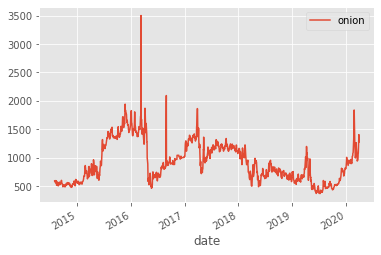

In [42]:
onion_price.plot()

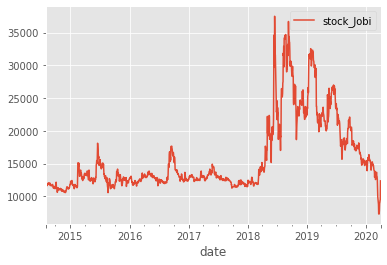

In [43]:
stock_Jobi.plot()

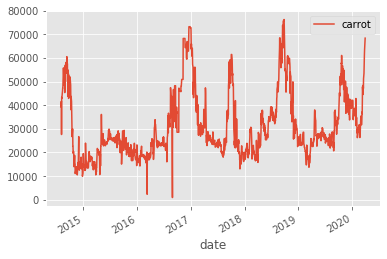

In [44]:
carrot_price.plot()

In [50]:
result_data = pd.concat([Stock_Asia, stock_Jobi, stock_Hyosung, stock_Farming, stock_Namhae_Chemical, stock_KGChemical, stock_Nongwoo_Bio, stock_Sungbo_Chemical, stock_Asia_Tech, stock_Eastern_Agro, stock_KPX, potato_price, tomato_price, green_pepper_price, red_pepper_price, cabbage_price, cabbage1_price, onion_price, carrot_price, green_onion_price, cucumber_price, Exchange_Rate, KOSPI, Oil_prices, Market_interest_rates], axis = 1)
# Stock_Asia
result_data.to_csv('result.csv', encoding = 'cp949')

In [51]:
def day_to_month(data):
    return data.resample('MS').mean()

result = pd.concat([Consumer_trend_survey, day_to_month(result_data)], axis = 1).corr()

result.style.background_gradient(cmap='summer_r')

,현재생활형편CSI,현재경기판단CSI,가계수입전망CSI,외식비 지출전망CSI,물가수준전망(1년후)CSI,stock_Asia,stock_Jobi,stock_Hyosung,stock_Farming,stock_Namhae_Chemical,stock_KGChemical,stock_Nongwoo_Bio,stock_Sungbo_Chemical,stock_Asia_Tech,stock_Eastern_Agro,stock_KPX,potato_price,tomato,green_pepper,red_pepper,cabbage,cabbage1,onion,carrot,green_onion,cucumber,Exchange_Rate,KOSPI,Dubai,Brent,WTI,시장금리
현재생활형편CSI,1.000000,0.650280,0.512357,0.491710,-0.557313,-0.175886,0.210573,-0.760676,0.336713,0.109657,-0.051212,-0.686429,-0.705908,0.219477,-0.018164,0.225687,0.206030,0.146817,-0.083398,-0.177253,0.088568,0.115717,-0.055194,0.338736,-0.104133,0.147068,-0.040278,0.536852,0.253409,0.226770,0.212399,-0.265671
현재경기판단CSI,0.650280,1.000000,0.758008,0.607717,-0.175040,-0.536401,-0.237618,-0.181572,-0.257048,-0.010239,0.051937,-0.116613,-0.189482,-0.293765,-0.066906,-0.194668,0.142792,-0.091572,-0.072338,-0.074613,-0.156413,-0.046851,0.161879,0.098053,-0.068308,-0.019457,-0.297728,0.430189,0.094164,0.099390,0.123543,-0.023879
가계수입전망CSI,0.512357,0.758008,1.000000,0.581325,-0.124332,-0.246213,0.086536,-0.125151,0.030166,0.244918,0.254309,-0.103258,-0.157172,-0.101908,0.105223,-0.209913,0.133348,-0.226087,-0.110522,-0.157380,-0.077078,-0.174325,-0.100049,0.161968,-0.168510,-0.010263,-0.468657,0.438945,0.410548,0.419205,0.418853,0.241828
외식비 지출전망CSI,0.491710,0.607717,0.581325,1.000000,0.117635,-0.321324,-0.048203,0.129743,0.024507,0.093080,0.127226,-0.030243,0.218844,-0.202324,-0.120725,-0.331828,0.214322,-0.122411,-0.064227,0.196137,-0.518583,-0.451577,-0.042067,-0.291104,-0.316697,0.022697,-0.335563,0.157542,0.261373,0.269971,0.229176,0.480869
물가수준전망(1년후)CSI,-0.557313,-0.175040,-0.124332,0.117635,1.000000,-0.257546,-0.581283,0.871229,-0.617687,-0.294263,-0.048451,0.841338,0.847407,-0.497394,-0.131295,-0.455995,-0.212313,-0.254338,0.078347,0.210634,-0.206202,-0.274447,0.096688,-0.399013,-0.064428,-0.125183,-0.290925,-0.457280,-0.115349,-0.075603,-0.016339,0.520969
stock_Asia,-0.175886,-0.536401,-0.246213,-0.321324,-0.257546,1.000000,0.490987,-0.037375,0.491762,0.265679,-0.055814,-0.052953,-0.054845,0.669271,0.315630,0.127970,-0.203423,-0.076844,-0.210614,-0.145386,-0.029581,-0.172609,-0.052027,-0.085768,0.119852,-0.097976,0.316535,-0.185006,-0.129535,-0.139095,-0.198362,-0.067241
stock_Jobi,0.210573,-0.237618,0.086536,-0.048203,-0.581283,0.490987,1.000000,-0.369185,0.806374,0.632221,0.286818,-0.528103,-0.403009,0.507242,0.307107,0.120183,0.133605,0.158114,-0.090791,-0.085435,-0.059607,-0.075877,-0.435672,0.252192,0.015560,-0.004385,0.037792,0.194929,0.450286,0.430391,0.324726,0.149498
stock_Hyosung,-0.760676,-0.181572,-0.125151,0.129743,0.871229,-0.037375,-0.369185,1.000000,-0.555877,-0.019028,0.210604,0.847449,0.856804,-0.436885,0.192813,-0.452404,-0.120982,-0.235828,0.020584,0.139473,-0.193162,-0.189339,0.133167,-0.368823,0.094965,-0.218724,-0.284045,-0.386647,-0.143559,-0.102301,-0.067862,0.455682
stock_Farming,0.336713,-0.257048,0.030166,0.024507,-0.617687,0.491762,0.806374,-0.555877,1.000000,0.305890,-0.108472,-0.721907,-0.498603,0.767864,0.097608,0.144051,0.039616,0.116661,-0.068443,-0.031150,-0.094960,-0.154076,-0.501378,0.140047,-0.244418,0.068099,0.259329,0.119123,0.437802,0.394795,0.289739,0.109695
stock_Namhae_Chemical,0.109657,-0.010239,0.244918,0.093080,-0.294263,0.265679,0.632221,-0.019028,0.305890,1.000000,0.794591,-0.114904,-0.141670,0.167343,0.642670,0.208224,0.447170,-0.165238,-0.225090,-0.192300,-0.184080,-0.199173,-0.156471,-0.029903,-0.041492,-0.230849,-0.343325,0.514350,0.343439,0.361498,0.315397,0.138958


In [52]:
result_data.corr().style.background_gradient(cmap='summer_r')

,stock_Asia,stock_Jobi,stock_Hyosung,stock_Farming,stock_Namhae_Chemical,stock_KGChemical,stock_Nongwoo_Bio,stock_Sungbo_Chemical,stock_Asia_Tech,stock_Eastern_Agro,stock_KPX,potato_price,tomato,green_pepper,red_pepper,cabbage,cabbage1,onion,carrot,green_onion,cucumber,Exchange_Rate,KOSPI,Dubai,Brent,WTI,시장금리
stock_Asia,1.000000,0.485173,-0.019894,0.497886,0.272650,-0.043929,-0.038668,-0.048838,0.641276,0.305964,0.121825,-0.190295,-0.041514,-0.142323,-0.109536,-0.025034,-0.154089,-0.047872,-0.080950,0.081586,-0.058473,0.281186,-0.152816,-0.106623,-0.115559,-0.169185,-0.049733
stock_Jobi,0.485173,1.000000,-0.340291,0.801692,0.622876,0.280926,-0.499798,-0.384757,0.498048,0.312059,0.116526,0.124797,0.128859,-0.064691,-0.071679,-0.034493,-0.059850,-0.398016,0.218239,0.006864,0.006421,0.030805,0.195041,0.435383,0.414931,0.312554,0.148940
stock_Hyosung,-0.019894,-0.340291,1.000000,-0.525815,-0.003648,0.215206,0.835705,0.837782,-0.372434,0.213835,-0.411417,-0.115459,-0.155000,0.008098,0.120629,-0.167412,-0.159762,0.126168,-0.344215,0.075884,-0.176046,-0.271805,-0.362934,-0.139837,-0.100113,-0.064961,0.435927
stock_Farming,0.497886,0.801692,-0.525815,1.000000,0.312744,-0.099982,-0.692133,-0.480989,0.739356,0.118288,0.136671,0.037427,0.092832,-0.050635,-0.023629,-0.077339,-0.129662,-0.468691,0.120868,-0.207540,0.060963,0.240038,0.125250,0.428859,0.385900,0.284996,0.115812
stock_Namhae_Chemical,0.272650,0.622876,-0.003648,0.312744,1.000000,0.777576,-0.097094,-0.137174,0.192159,0.607698,0.205720,0.409027,-0.105425,-0.154929,-0.157746,-0.160553,-0.162732,-0.140001,-0.040785,-0.045136,-0.178559,-0.336007,0.511487,0.332533,0.348813,0.304281,0.136905
stock_KGChemical,-0.043929,0.280926,0.215206,-0.099982,0.777576,1.000000,0.117779,0.031346,-0.224288,0.519808,0.085574,0.471797,-0.073231,-0.070804,-0.097281,-0.060319,0.033292,-0.005429,-0.053916,0.033733,-0.116513,-0.521101,0.564678,0.278423,0.311524,0.288368,0.130236
stock_Nongwoo_Bio,-0.038668,-0.499798,0.835705,-0.692133,-0.097094,0.117779,1.000000,0.713512,-0.399297,0.128101,-0.215091,-0.223979,-0.237019,0.026874,0.067572,-0.021708,-0.135205,0.166710,-0.289564,0.111952,-0.198525,-0.305980,-0.322334,-0.243897,-0.183324,-0.091778,0.294182
stock_Sungbo_Chemical,-0.048838,-0.384757,0.837782,-0.480989,-0.137174,0.031346,0.713512,1.000000,-0.352008,-0.063240,-0.363316,-0.144470,-0.112326,-0.030115,0.175833,-0.145119,-0.174520,0.322416,-0.376798,0.149692,-0.081689,-0.028727,-0.486252,-0.275549,-0.237826,-0.217002,0.419829
stock_Asia_Tech,0.641276,0.498048,-0.372434,0.739356,0.192159,-0.224288,-0.399297,-0.352008,1.000000,0.204060,0.264151,-0.030336,0.053856,-0.050157,-0.038525,0.021337,-0.084181,-0.167165,0.016002,-0.143373,0.042073,0.335837,0.062028,0.079810,0.048809,-0.000330,-0.116732
stock_Eastern_Agro,0.305964,0.312059,0.213835,0.118288,0.607698,0.519808,0.128101,-0.063240,0.204060,1.000000,0.204037,0.180499,-0.113823,-0.241168,-0.372776,0.020768,0.036673,-0.068408,0.034465,0.047507,-0.339846,-0.259563,0.428899,0.231905,0.242895,0.243953,-0.067784
